# 4. Data Modeling

<a id="contents"></a>
# Table of Contents  
4.1. [Introduction](#introduction)  
4.2. [Imports](#imports)   
4.3. [Load Pre-processed Data](#load)     
4.4. [Model Definition and Training](#define)      
4.5. [Model Evaluation](#eval)      
4.6. [Save the Trained Model](#results)<br>

## 4.1 Introduction<a id="introduction"></a>

The goal of this notebook is to develop predictive models that can accurately forecast future real estate market trends, specifically focusing on rental income potential, property values, and investment returns. 

## 4.2 Imports<a id="imports"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import joblib
import time
from xgboost import XGBRegressor

## 4.2 Load Pre-processed Data

In [2]:
# Load the preprocessed data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Verify data shapes
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (47088, 19)
Test data shape: (11772, 19)


## 4.3 Model Definition and Training

In [3]:
# Define models and parameter grids
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
}

param_grids = {
    'GradientBoosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None]
    }
}

In [4]:
# Function to train and evaluate models
def train_and_save_model(X_train, y_train, X_test, y_test, models, param_grids):
    best_model = None
    best_score = float('inf')
    best_model_name = None
    
    for model_name, model in models.items():
        search = RandomizedSearchCV(model, param_grids[model_name], n_iter=3, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
        
        # For XGBRegressor, include early stopping
        if model_name == 'XGBRegressor':
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
        else:
            search.fit(X_train, y_train)
            model = search.best_estimator_
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
        
        if rmse < best_score:
            best_score = rmse
            best_model = model
            best_model_name = model_name
        
        if model_name != 'XGBRegressor':
            print(f"{model_name} - Best Parameters: {search.best_params_} - RMSE: {rmse}")
        else:
            print(f"{model_name} - RMSE: {rmse}")
    
    return best_model, best_model_name, best_score

## 4.4 Model Evaluation

In [5]:
best_model, best_model_name, best_score = train_and_save_model(X_train, y_train, X_test, y_test, models, param_grids)
print(f"Best model is {best_model_name} with RMSE: {best_score}")

GradientBoosting - Best Parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1} - RMSE: 0.30246505897252285


/Users/heatheradler/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor - RMSE: 0.2870797035074488
RandomForestRegressor - Best Parameters: {'n_estimators': 300, 'max_depth': 20} - RMSE: 0.29099695076771975
Best model is XGBRegressor with RMSE: 0.2870797035074488


## 4.5 Model Evaluation

MAE (Train): 0.15728964888937158, MAE (Test): 0.17729633909625195
MSE (Train): 0.06331682870168007, MSE (Test): 0.08241475616592471
RMSE (Train): 0.2516283543277269, RMSE (Test): 0.2870797035074488
R2 (Train): 0.7838999184101512, R2 (Test): 0.7169744072515661


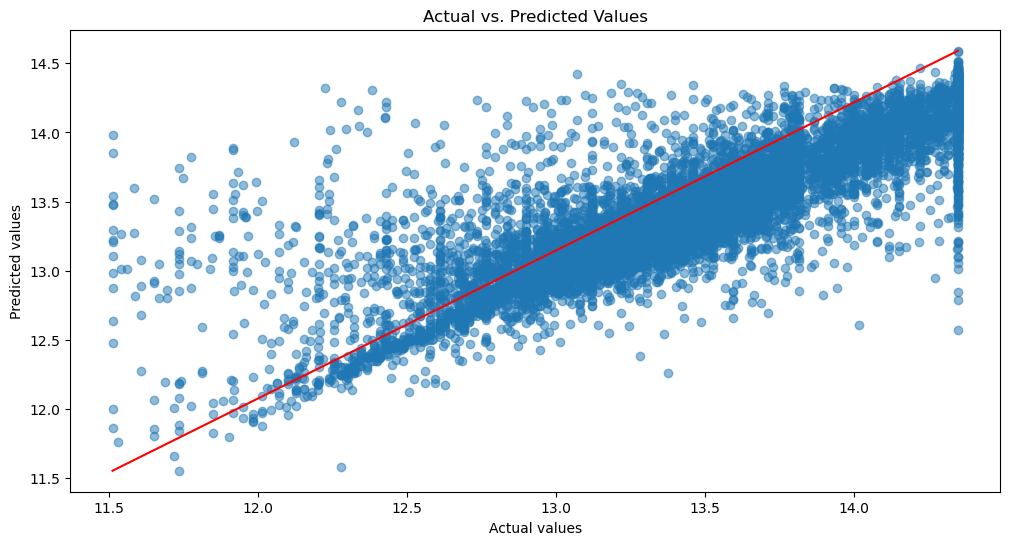

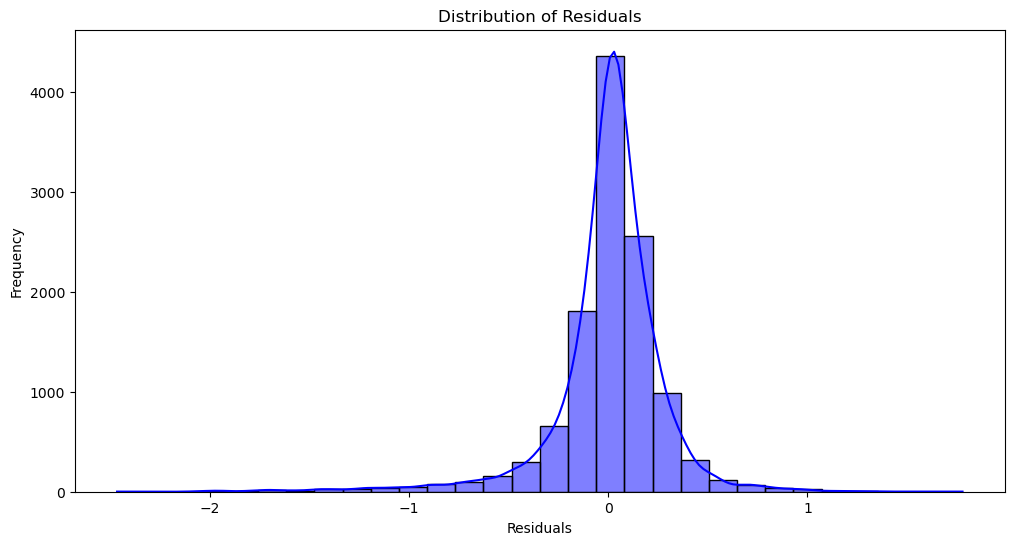

In [6]:
# Define evaluation function with visualizations
def evaluate_model_with_visualization(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"MAE (Train): {mae_train}, MAE (Test): {mae_test}")
    print(f"MSE (Train): {mse_train}, MSE (Test): {mse_test}")
    print(f"RMSE (Train): {rmse_train}, RMSE (Test): {rmse_test}")
    print(f"R2 (Train): {r2_train}, R2 (Test): {r2_test}")

    # Plotting the actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test_pred), max(y_test_pred)], color='red')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()

    # Plotting residuals
    residuals = y_test - y_test_pred
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, bins=30, color='blue')
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

# Evaluate the best model
evaluate_model_with_visualization(best_model, X_train, y_train, X_test, y_test)

## 4.6 Save the Trained Model

In [7]:
joblib.dump(best_model, f'best_model_{best_model_name}.pkl')

['best_model_XGBRegressor.pkl']